In [1]:
# 40X the accuracy is 78 training, 81.5 validation and 80 Test accuracy
# 100X the accuracy is 80 training, 77 validation and 80 Test accuracy

# https://scisharp.github.io/Keras.NET/api/Keras.Applications.DenseNet.DenseNet201.html
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import cv2
from PIL import Image
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn import metrics
import itertools
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#image_magnification=['40X','100X','200X','400X']

In [4]:
# # https://stackoverflow.com/questions/273946/how-do-i-resize-an-image-using-pil-and-maintain-its-aspect-ratio
# target=[]
# raw_IMG = []
# def Dataset_loader(DIR, RESIZE, sigmaX=200):
#     IMG = []
#     read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
#     for IMAGE_NAME in tqdm(os.listdir(DIR)):
#         PATH = os.path.join(DIR,IMAGE_NAME)
#         _, ftype = os.path.splitext(PATH)
#         if ftype == ".png":
#             img = read(PATH)
#             raw_IMG.append(np.array(img))
#             img = cv2.resize(img, (RESIZE,RESIZE))
           
#             IMG.append(np.array(img))
            
#             if re.search("malignant", DIR):
#                 target.append(1)
#             else:
#                 target.append(0)
                
#             #print(img.shape)
#     return IMG

# path=os.walk('/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/Capstone A/Code/breast')

# tumor=[]
# for root,directories, files in path:
    
#     for directory in directories:
#         if directory in image_magnification[2]:
#             tumor.append(np.array(Dataset_loader(root+'/'+directory,224)))               
#             #print(root+'/'+directory)

# tumor_final=np.array(list(itertools.chain.from_iterable(tumor)))

# tumor_final.shape

In [5]:
#loading the saved file once again
tumor_final = np.load(os.path.join('/content/drive/MyDrive/Capstone','features_40.npy'), 
                allow_pickle=True)

#loading the saved file once again
target = np.load(os.path.join('/content/drive/MyDrive/Capstone','target_40.npy'), 
                allow_pickle=True)

In [6]:
df = pd.DataFrame(target,columns=['target'])
df.head()

,target
0,0
1,0
2,0
3,0
4,0


In [7]:
df.value_counts()

target
1         1370
0          625
dtype: int64

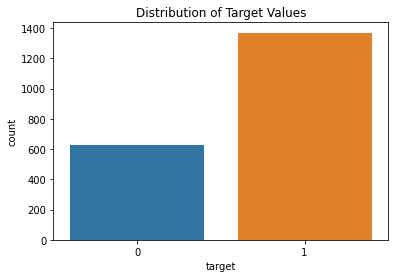

In [8]:
import seaborn as sns
sns.countplot(x = "target", data = df)
plt.title("Distribution of Target Values")
plt.show()


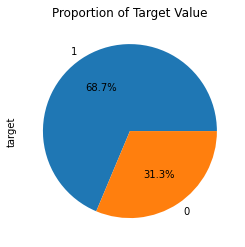

In [9]:
# Pie chart
df['target'].value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

In [10]:
# msk_negative = df['target'] == 0
# msk_positive = df['target'] == 1

# df_positive_undersample = df[msk_positive].sample(n=msk_negative.sum(), random_state=888)
# df_train_undersample = pd.concat([df_positive_undersample, df[msk_negative]])
# df_train_undersample['target'].value_counts()


In [11]:
# target_under = df_train_undersample['target']

In [12]:
# df_negative_undersample.index

In [13]:
# tumor_final_new = tumor_final[df_train_undersample]

In [14]:
# tumor_final_new

In [15]:
from sklearn.model_selection import train_test_split

#X_train, X_test, Y_train, Y_test = train_test_split(tumor_final_new/255., target_under, test_size=0.2, random_state=42, shuffle=True)

X_train, X_test, Y_train, Y_test = train_test_split(tumor_final/255., target, test_size=0.2, random_state=42, shuffle=True)

print(pd.DataFrame(Y_test)[0].value_counts())

print(pd.DataFrame(Y_train)[0].value_counts())

# random shuffling the training images and target
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = np.array(Y_train)[s]

# random shuffling the Test images and target
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = np.array(Y_test)[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)


1    265
0    134
Name: 0, dtype: int64
1    1105
0     491
Name: 0, dtype: int64


In [16]:
Y_train = Y_train.astype(int)
counts = np.bincount(Y_train[:, 0])
#weight_for_0 = 1.0 / counts[0]
#weight_for_1 = 1.0 / counts[1]
weight_for_0 = counts[0]/ (counts[0] + counts[1])
weight_for_1 = counts[1]/ (counts[0] + counts[1])
class_weight = {0: weight_for_0, 1: weight_for_1}

In [17]:
class_weight

{0: 0.6923558897243107, 1: 0.3076441102756892}

In [18]:
X_train[0].shape

(224, 224, 3)

In [19]:
#img = X_train[0].reshape[1:]

In [20]:
#img

In [21]:
#X_train[0][img].shape

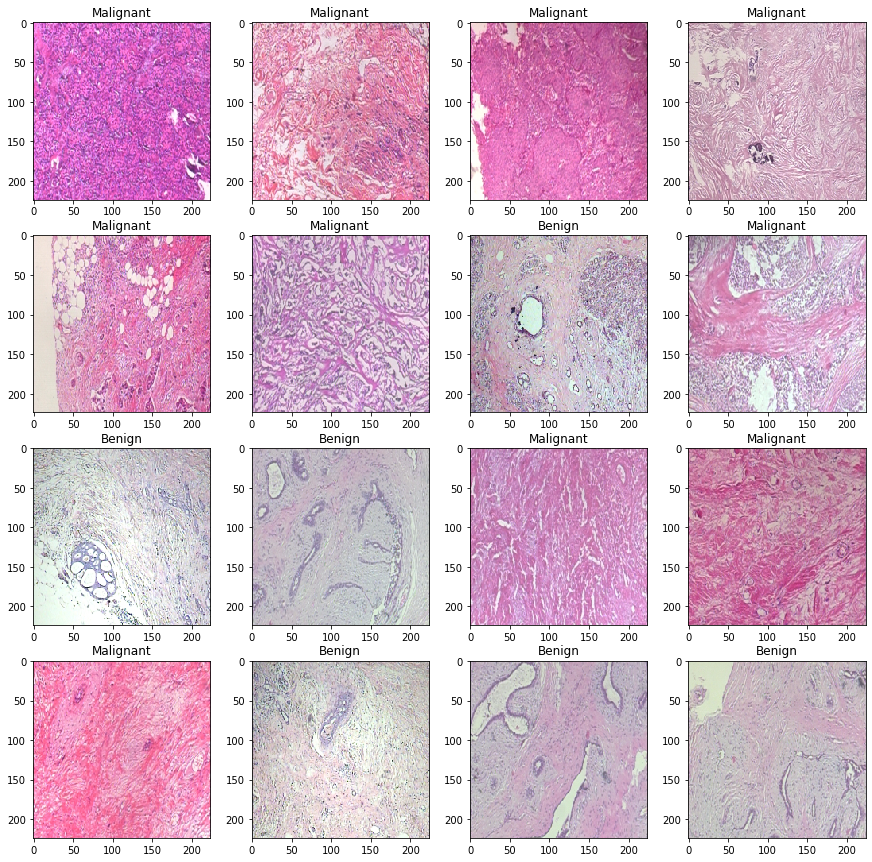

In [22]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11,
    shuffle=True
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [23]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as  PretrainedModel,preprocess_input
from tensorflow.keras.optimizers import SGD

def build_model(backbone, lr=1e-3):
    model = Sequential()
    model.add(backbone)
    # model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(4096,activation='swish'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(2048,activation='swish'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(4096,activation='swish'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(2, activation='sigmoid'))
    
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(
        loss='binary_crossentropy',
       # optimizer=SGD(lr=0.01, momentum=0.9,nesterov=False),
        optimizer = Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

#resnet = tf.keras.applications.inception_v3.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
#resnet = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

for layer in resnet.layers:
	layer.trainable = False

model = build_model(resnet ,lr = 1e-3)


58900480/58889256 [==============================] - 0s 0us/step


In [24]:
for layer in model.layers:
  print(layer.name)
	#layer.trainable = False


vgg16
flatten
dense
batch_normalization
dropout
dense_1
batch_normalization_1
dropout_1
dense_2
batch_normalization_2
dropout_2
dense_3


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                        

In [26]:
# Generate batches of tensor image data with real-time data augmentation.

BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range=0.2
    )

In [27]:
# https://stackoverflow.com/questions/35074549/how-to-load-a-model-from-an-hdf5-file-in-keras

# https://keras.io/api/callbacks/reduce_lr_on_plateau/

# Reduce learning rate when a metric has stopped improving.
learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

safety = EarlyStopping(monitor='val_loss', patience=4, min_delta=2e-4)

# Callback to save the Keras model or model weights at some frequency.
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# history = model.fit_generator(
#     train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
#     steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
#     epochs=50,
#     validation_data=(x_val, y_val),
#     callbacks=[learn_control, checkpoint],
#     class_weight=class_weight
# )

history = model.fit(
    x_train, y_train, batch_size=BATCH_SIZE,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint],
    class_weight=class_weight
)

Epoch 1/50
79/79 [==============================] - 18s 79ms/step - loss: 0.6775 - accuracy: 0.6669 - val_loss: 4.2537 - val_accuracy: 0.4031 - lr: 0.0010
Epoch 2/50
79/79 [==============================] - 5s 68ms/step - loss: 0.2295 - accuracy: 0.8002 - val_loss: 1.0165 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/50
79/79 [==============================] - 5s 68ms/step - loss: 0.1361 - accuracy: 0.8715 - val_loss: 0.6403 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 4/50
79/79 [==============================] - 5s 68ms/step - loss: 0.1024 - accuracy: 0.9099 - val_loss: 0.6697 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/50
79/79 [==============================] - 5s 67ms/step - loss: 0.1109 - accuracy: 0.9099 - val_loss: 0.6308 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 6/50
79/79 [==============================] - 5s 67ms/step - loss: 0.0652 - accuracy: 0.9444 - val_loss: 1.0987 - val_accuracy: 0.8031 - lr: 0.0010
Epoch 7/50
79/79 [==============================] - 6s 73ms/step - loss: 0.

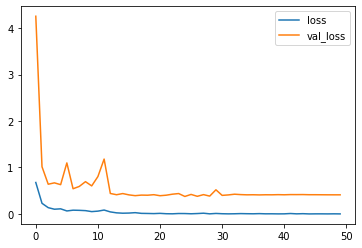

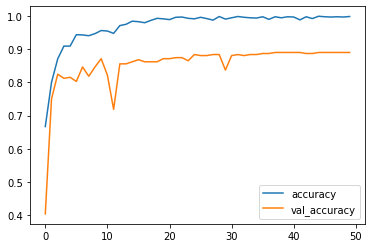

In [28]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [29]:
X_train.shape

(1596, 224, 224, 3)

In [30]:
y_pred=model.predict(X_test)

In [31]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       134
           1       0.91      0.89      0.90       265

    accuracy                           0.87       399
   macro avg       0.85      0.86      0.85       399
weighted avg       0.87      0.87      0.87       399



Confusion matrix, without normalization
[[110  24]
 [ 28 237]]


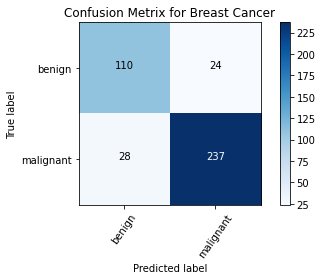

In [32]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

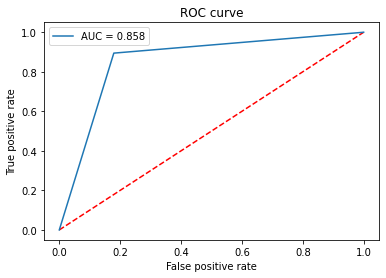

In [33]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))*100

86.96741854636592

In [36]:
#from tensorflow import keras

In [37]:
#model.save('/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/Capstone A/Code/breast')